# Hotelling Law Model

<div class="admonition note">
    <p class="admonition-title">In progress</p>
    <p>This document is a work in progress if you see any errors, or exclusions or have any problems, please <a href="https://github.com/absespy/ABSESpy/issues">get in touch with us</a>.</p>
</div>

For the first time, we are going to use the `ABSESpy` package to create a model by customizing **BOTH** the `Actor` and `PatchCell` classes

The major technics introduced here are including:
1. **link**: Linking `Actor`s and `PatchCell`s, searching and counting linkages.
2. **schedule**: Use `step()` and `advance()` method to separate decision and action for agents.

We will use the Hotelling Law model as an example. The model is based on the assumption that firms will locate themselves in a way that minimizes the distance to their customers. The model is named after Harold Hotelling, who introduced it in 1929. The counterpart written in NetLogo can be found [here](https://ccl.northwestern.edu/netlogo/models/Hotelling'sLaw). 

Let's start by sketching some new classes, for grouping the basic functions separately.

- The main model class will be a subclass of `MainModel`, controlling global behaviors as usual.
- In this case, `Actor` should be some `Shop`s, who may adjust its location and price for better revenue (attracted customers and production's price).
- The `PatchCell` class simulates customers whose locations decide their preferences to shops.

In [1]:
from abses import Actor, MainModel, PatchCell


class Customer(PatchCell):
    """
    Each patch cell represents a customer.
    Customer prefers to buy from the nearest & cheapest shop.
    """


class Shop(Actor):
    """Shop class, which may adjust location and prices."""


class Hotelling(MainModel):
    """Model class for Hotelling's Law."""

## Link customers with their prefer shop

Following the netlogo implementation, each agent will begin at a random position. It will have a market area or share depending on its price and position. Each cell or patch of the grid is considered a customer with inelastic demand for the product. Each customer will make a choice as to what shop is prefered based on the price and distance to each shop. In the original paper (1929) the distance to the shop introduces transportation costs.

We first may wish to work out all the setup: **create a grid layer and randomly set shop agents on the layer**.

In [2]:
class Hotelling(MainModel):
    """
    Model class for the Hotelling's Law example.
    """

    def setup(self):
        num_agents = self.params.get("n_agents", 3)  # default to 3
        # Initialize a grid of shape (10, 10)
        layer = self.nature.create_module(
            cell_cls=Customer,  # notice that we use the customized class
            how="from_resolution",
            shape=(10, 10),
        )

        # Create some agents on random cells
        shops = self.agents.new(Shop, num_agents)
        shops.apply(lambda shop: shop.move.to("random", layer=layer))

Imagine that we have a 10x10 grid where each cell represents a custom. We also placed some shops (based on the `num_agents` parameter) on the world. We need to calculate the distance between each customer and each shop, and then calculate the preference of each customer to each shop.

Therefore, let's add a custom method to the `Customer` class to calculate the preference of each customer to each shop.

In [3]:
import numpy as np
from scipy.spatial.distance import cdist


class Customer(PatchCell):
    """
    Each patch cell represents a customer.
    Customer prefers to buy from the nearest & cheapest shop.
    """

    def find_preference(self):
        """Find the nearest & cheapest shop."""
        self.link.clean()  # clean all existing links
        stores = self.model.actors
        # Create a list of all shops
        prices = stores.array("price")
        # Create a list of all distances from the customer to each shop
        distances = cdist(
            np.array([self.pos]),
            np.array([shop.at.pos for shop in stores]),
        )[0]
        # Pair each shop to its distance & price
        _pair = dict(zip(stores, distances + prices))
        prefer_store = min(_pair, key=_pair.get)
        # let this customer be linked by the nearest & cheapest shop.
        self.link.by(prefer_store, link_name="prefer")
        return prefer_store

Distance is calculated using the Euclidean distance formula. The preference of each customer to each shop is calculated using the formula $prefer = price + distance$:

In the above implementation, we use `scipy.spatial.distance` module to calculate the distance between each customer and each shop. We also use the `numpy` module to calculate the preference of each customer to each shop.

<div class="admonition note">
    <p class="admonition-title">In progress</p>
    <p>Calculating distance between cell and actors is not an internal method at the moment, but we are considering becoming the default feature of ABSESpy in the future.</p>
</div>


For flexibility, we also need another custom method to the `MainModel` to refresh the preferences globally:

In [4]:
class Hotelling(MainModel):
    """
    Model class for the Hotelling's Law example.
    """

    def setup(self):
        num_agents = self.params.get("n_agents", 3)
        # Initialize a grid
        layer = self.nature.create_module(
            cell_cls=Customer, how="from_resolution", shape=(10, 10)
        )

        # Create some agents on random cells
        shops = self.agents.new(Shop, num_agents)
        shops.apply(lambda shop: shop.move.to("random", layer=layer))

    def recalculate_preferences(self):
        """Let all customers (PatchCell) find their preferences shop."""
        self.nature.major_layer.select().trigger("find_preference")

Now, what we've done?

We have customers located on different cells of the grid, and initialized some shops. We have calculated the distance between each customer and each shop, and then calculated the preference of each customer to each shop. Finally, we also added a custom method to the `MainModel` to refresh the preferences globally.

Notice that we used `link.by()` method to link each customer to the shop it prefers. `link` is a powerful function of `ABSESpy` to link two agents, cells, or agent and cell. Users can customize the linkages' name by specifying `link_name` parameter. In this case, we use `prefer` as the linkage name. Once we've created the links, we can easily access the linked cells from the shops' side, including counting the number of customers who prefer each shop. Let's add a custom method to the `Shop` class to count the number of customers who prefer each shop to test it.

In [5]:
from abses.main import MainModel


class Shop(Actor):
    """Shop class, which may adjust location and prices."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # add a fixed price attribute to each shop
        self.price = 10.0

    @property
    def area_count(self) -> int:
        """Return the number of customers in the shop's area."""
        return len(self.link.get("prefer", direction="out"))

Now, each shop can count the number of customers who prefer it by access the property `area_count`. We simply add a fixed price for each shop so that customers can calculate their preferences.

Let's initialize a model, setup it, and calculate the preferences of each customer to each shop. Then, we can count the number of customers who prefer each shop.

In [6]:
model = Hotelling()
model.setup()
model.recalculate_preferences()

assert sum(model.actors.array("area_count")) == 100
model.actors.array("area_count")

[2024-03-20 15:05:59][human          ] | Initializing a new Human Module...
[2024-03-20 15:05:59][nature         ] | Initializing a new Base Nature module...
[2024-03-20 15:05:59][nature         ] | Initializing a new Model Layer...
[2024-03-20 15:05:59][nature         ] | Using rioxarray version: 0.13.4
[2024-03-20 15:05:59][container      ] | Created 3 actors of breed Shop


array([100,   0,   0])


Sum of the three number should be 100, which means each cell on the grid ($10 * 10$ by default) has been linked to the shop it prefers.

## Schedule shop's decision and action


We are prepared to implement the full `Shop` class now.

Besides the `area_count` property, we are going to take `setup` method to give our Shop agent the following parameters:

|attribute|description|
|---|---|
|price|Shop's current price|
|next_position|Position to advance to at the end of this period|
|next_price|Price to set at the end of this period|

The next position and next price are the variables that will be used to store the agent's choices on position and price momentarily and that will take effect at the end of the period. By separating the decision and action in a schedule, we can simulate the shops' decision are made simultaneously.

We will want to be able to calculate respective monopoly areas for each shop. Since no single agent can really set this variable for himself, this method must be implement within the scope of the Hotelling model class scope. Essentially, it will iterate through each path or cell and it will define what would be the preferred shop for a customer that sits on that cell. The area for any given Shop is the number of customer that prefer that shop.

We are going to need a function to calculate the distance between any two points in the grid. We will use the euclidean distance. We proceed to take this distance as the nominal value of the transportation costs, assuming each unit of distance equates one unit of money.

This distance plus the price will define the total costs that a customer incurs when buying from a given shop.

The preferred shop will be the cheapest one. That is, the one for which the customer faces less costs for both the product itself and transportation. The method will return a dictionary with the number of customers that prefer each shop.

In [7]:
class Shop(Actor):
    """
    Shop agent
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.price = 10
        self.next_position = None
        self.next_price = None

    @property
    def area_count(self) -> int:
        """Return the number of customers in the shop's area."""
        return len(self.link.get("prefer", direction="out"))

    def step(self):
        self.adjust_price()
        self.adjust_position()

    def advance(self):
        self.affect_price()
        self.affect_position()

    def adjust_price(self):
        """Evaluate the potential revenue for each possible price change.
        Choose the one with the highest potential revenue."""
        # Save initial price
        init_price = self.price

        # Build a list of all possible prices
        _possible_prices = [init_price - 1, init_price, init_price + 1]

        # Pair each possible price change to its potential revenue
        _potential_revenues = {}
        for price in _possible_prices:
            self.price = price
            self.model.recalculate_preferences()
            _potential_revenues[price] = self.area_count * price
        # Check if all potential revenues are 0
        # if so, decrease price by 1
        if all(value == 0 for value in _potential_revenues.values()):
            self.next_price = self.price - 1
        # Otherwise, choose the price with the highest potential revenue
        else:
            self.next_price = max(
                _potential_revenues, key=_potential_revenues.get
            )

        # Reset price to initial price
        self.price = init_price

    def adjust_position(self):
        """Evaluate the potential areas for each possible move.
        Choose the one with the highest potential area."""
        cell_now = self.at
        # Get all possible candidates for the next position
        _possible_moves = self.at.neighboring(moore=True, include_center=False)

        # Pair each possible move to their potential areas
        _potential_areas = {}
        for move in _possible_moves:
            self.move.to(move)
            self.model.recalculate_preferences()
            _potential_areas[move] = self.area_count

        # Single out the store with the highest potential area and save it
        _choice = max(_potential_areas, key=_potential_areas.get)
        self.next_position = _choice

        # Pull back to initial position if the potential area
        self.move.to(cell_now)

    def affect_price(self) -> None:
        """Change the price of the shop to the next price."""
        self.price = self.next_price

    def affect_position(self) -> None:
        """Change the position of the shop to the next position."""
        self.move.to(self.next_position)

The above implementation is a bit complicated but don't be daunted.
We use the `step()` method to make decisions and the `advance()` method to take actions.
When making decision, each shop consider all the potential movements and prices, and choose the one that maximizes its revenue. Then, it sets the next position and next price. When taking action, each shop moves to the next position and sets the next price.

The price adjustme schedule are part of the `Shop` class in the Hotelling model. There are two methods that relate to this procedure, namely, `adjust_price` and `adjust_position`. Here's a detailed description of how it works:

1. **adjust_price**: This method is responsible for determining the next price for the shop based on potential revenues.

   - It first saves the current price of the shop in `initial_price`.
   
   - It then creates a list of possible prices, which are the current price minus 1, the current price, and the current price plus 1.
   
   - For each possible price, it temporarily sets the shop's price to that value and calculates the potential revenue if the shop were to sell at that price. The potential revenue is calculated as the product of the price and the area of the shop's monopoly, which is obtained by calling the `recalculate_areas` method of the model.
   
   - If all potential revenues are 0, it sets `next_price` to be the current price minus 1. This means that if the shop cannot make any revenue at any of the possible prices, it will lower its price in the next step.
   
   - If there is at least one possible price that can generate revenue, it sets `next_price` to be the one that generates the highest potential revenue.
   
   - Finally, it resets the shop's price to the initial price. This is because the actual price change does not occur in the `adjust_price` method. Instead, the new price is stored in `next_price` and the price change is applied in the `affect_price` method.

2. **affect_price**: This method is responsible for applying the price change that was determined in the `adjust_price` method.

   - It simply sets the shop's price to `next_price`. This is the new price that was determined in the `adjust_price` method.

The `adjust_price` and `affect_price` methods are called in the `step` and `advance` methods of the `Shop` class, respectively. This allows all shops to make their decisions based on the current state of the model in the `step` method, and then all decisions are applied simultaneously in the `advance` method.

Next we write the methods relating to the position adjustment schedule. Here's a detailed description of how they work:

1. **adjust_position**: This method is responsible for determining the next position for the shop based on potential areas.

   - It first saves the current position of the shop in `initial_pos`.
   
   - It then gets a list of all possible moves the shop can make. This is done by calling the `get_neighborhood` method of the `major_layer` attribute of the model, which returns the neighboring cells of the shop's current position. The `major_layer` is a BaseNature instance that represent one grid of the model.
   
   - For each possible move, it temporarily moves the shop to that position and calculates the potential area of the shop's monopoly if it were to move to that position. The potential area is calculated by calling the `recalculate_areas` method of the model.
   
   - It then selects the move that results in the largest potential area and stores it in `next_position`.
   
   - Finally, it moves the shop back to its initial position. This is because the actual move does not occur in the `adjust_position` method. Instead, the new position is stored in `next_position` and the move is applied in the `affect_position` method.

2. **affect_position**: This method is responsible for applying the move that was determined in the `adjust_position` method.

   - It simply moves the shop to `next_position`. This is the new position that was determined in the `adjust_position` method.

The `adjust_position` and `affect_position` methods are called in the `step` and `advance` methods of the `Shop` class, respectively. This allows all shops to make their decisions based on the current state of the model in the `step` method, and then all decisions are applied simultaneously in the `advance` method.

From the previous implementation of the Hotelling model class, we already have cues as to what we should aim for and tackle. We know there must be a step and an advance method. We also know that the agent must make a decision regarding price and position based on the number of customer that prefer buying from them, thus, increasing profits and staying in business. Therefore, we will design the Shop agent class in a way that reflect this. There will be the two methods already mentioned and for each there will be two routines. 

First, the `step` method will be called for all agents. In it, there will be two routines regarding the changes in prices and positions respectively. At each step, each agent is going to adjust its price and position, but those changes will only take effect at a later stage. The reason for this is that we want to make sure that all agents have made their decisions before any of them takes effect. This may also be referred to as a synchronous or simultaneous update. In order to do that, we want to save the changes in a variable that will be used to update the agent's attributes at the end of the step. This is the reason behing having the `next_price` and `next_position` attributes. 

Taken together, to make the implementation, we have to change the main model a little bit more:

In [8]:
from mesa.time import SimultaneousActivation


class Hotelling(MainModel):
    """
    Model class for the Hotelling's Law example.
    """

    def setup(self):
        # change the schedule to SimultaneousActivation
        self.schedule = SimultaneousActivation(self)

        # intact the previous setup method
        num_agents = self.params.get("n_agents", 3)
        # Initialize a grid
        layer = self.nature.create_module(
            cell_cls=Customer, how="from_resolution", shape=(10, 10)
        )

        # Create some agents on random cells
        shops = self.agents.new(Shop, num_agents)
        shops.apply(lambda shop: shop.move.to("random", layer=layer))

    def step(self):
        # recalculate areas and assign them to each agent
        self.recalculate_preferences()

    def recalculate_preferences(self):
        """Let all customers (PatchCell) find their preferences shop."""
        self.nature.major_layer.select().trigger("find_preference")

Super easy, right? We only added two lines:

```python
# change the schedule to SimultaneousActivation
self.schedule = SimultaneousActivation(self)
```

It means, we are going to use the `SimultaneousActivation` scheduler to make sure all agents make their decisions before any of them takes effect.

By default, the model takes three actions in each time tick:

1. Trigger each `step` in model, nature, and human in order.
2. Trigger each `step` for agents.
3. Collecting data.

When we use `SimultaneousActivation` scheduler, the second action will be changed to:

2. Trigger each `step`, and then `advance` for agents.

It allows us to separate decision and action for agents. Shops make decision about their movements and prices in `step` method, and then take action in `advance` method simultaneously.

In [9]:
params = {
    "reports": {
        "agents": {
            "area": "area_count",
            "price": "price",
        }
    },
    "time": {"end": 20},
    "model": {"n_agents": 2},
}

model = Hotelling(parameters=params)
model.run_model()

[2024-03-20 15:05:59][human          ] | Initializing a new Human Module...
[2024-03-20 15:05:59][nature         ] | Initializing a new Base Nature module...
[2024-03-20 15:05:59][main           ] | Setting up Hotelling...
[2024-03-20 15:05:59][nature         ] | Initializing a new Model Layer...
[2024-03-20 15:05:59][nature         ] | Using rioxarray version: 0.13.4
[2024-03-20 15:05:59][container      ] | Created 2 actors of breed Shop
[2024-03-20 15:06:00][main           ] | Ending Hotelling


Once we have a full working and testable version of our model, we instantiate it and run it. The following code block shows how to do this:

1. **Define the Parameters**

   The `parameters` dictionary is defining the parameters for the simulation. In this case, there's only one parameter: `end`. This parameter is nested under `time` and is set to `20`. This means the simulation will run for 100 time steps.

2. **Instantiate the Model**

   The `Hotelling` model is being instantiated with `n_agents=2` and `parameters=parameters`. This means that the model will start with 2 agents (as specified by `N=2`) and will use the parameters defined in the `parameters` dictionary. 

3. **Run the Model**

   The `run_model` method is called on the `model` instance. This starts the simulation and runs it until the end time specified in the parameters (in this case, 100 time steps).

The `Hotelling` model is a type of agent-based model used in economics to simulate competition between two firms (or agents) in a geographical market. The `n_agents=2` parameter suggests that there are two firms in the simulation. The firms adjust their prices and locations in each time step based on the state of the market, and the simulation tracks these adjustments over time.

## Data Visualization

In [10]:
model.datacollector.get_agent_vars_dataframe()

area  price
Step AgentID             
1    1          36     10
     2          64      9
2    1          18      9
     2          82      9
3    1          50      8
     2          50      8
4    1          50      7
     2          50      7
5    1          55      6
     2          45      6
6    1          60      5
     2          40      5
7    1          50      4
     2          50      4
8    1          64      3
     2          36      3
9    1          60      2
     2          40      2
10   1          60      2
     2          40      2
11   1          50      1
     2          50      2
12   1          72      2
     2          28      2
13   1          65      2
     2          35      1
14   1          39      1
     2          61      2
15   1          72      2
     2          28      2
16   1          50      2
     2          50      2
17   1          50      1
     2          50      2
18   1         100      1
     2           0      1
19   1          50      1
     2          50      2
20   1          65      1
     2          35      1

We now have a working model. The `datacollector` attribute allows to access data collected during the execution of the model. We mainly want to observe the evolution of key variables that describe model's state. For this example, we want to observe the price of each shop at each time step. We also want to observe the number of customers that prefer each shop at each time step. The following code block shows how to do this:

<Axes: xlabel='Step'>

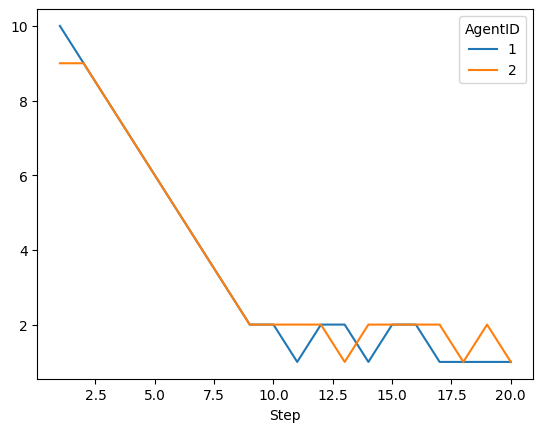

In [11]:
results = model.datacollector.get_agent_vars_dataframe()

results.unstack(level=1).price.plot()

As the Hotelling's Law model would predict, the two shops converge to a lower and similar price. This contributes to our understading of how competitions occurs between firms in a market for two substitute goods. The model can be further developed to include more shops, more dimensions, and more complex decision making processes.

We may proceed to add three more shops to our model and evaluate the differences.

After extending the model to inlcude 5 shops, we can appretiate how some shops are now able to hold higher prices for longer periods after well advanced time periods. Hotelling (1929) considered that all shops or sellers are a monopoly within the confines of a smaller jurisdiction or area. It is appearently the case that more shops allow for less localised competition and, thus, higher prices in certain areas.

We can also explore those relative positions in our grid, the areas of each shop and respective revenues. This example only aims to provide a quick illustration of how to use the ABSESpy package.

## References
Hotelling, H. (1929). Stability in competition. The Economic Journal, 39(153), 41-57.